Copyright @ 2021 ABCOM Information Systems Pvt. Ltd. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.


# Hyper-Parameter Tuning using Optuna


To install Optuna library execute pip install optuna 

In [1]:
pip install optuna

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 210 kB 34.0 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 113 kB 46.7 MB/s 
     |████████████████████████████████| 150 kB 41.4 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1a743e3cc3c358ac033be53d261417f80f44751d50e83fa8ac7a6b9826952dd3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


### Required packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.svm import SVR
import optuna as op
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Fetching dataset


In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/abcom-mltutorials/Optuna/main/CCPP.csv")

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


### Feature and Target Selection


In [5]:
X=df.drop("PE",axis=1)
Y=df.PE

### Splitting Dataset


In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

In [7]:
print("train: ",X_train.shape)
print("test: ",X_test.shape)

train:  (7654, 4)
test:  (1914, 4)


### Baseline Model

First we will create a model without any parameter tuning to understand effect of parameter tuning at the later stage

In [8]:
model=SVR()
model.fit(X_train,y_train)

SVR()

#### Model accuracy

In [9]:
model.score(X_test,y_test)

0.38922787580732543

### Optuna Hyperparameter Tuning

In this section we will try to maximize our accuracy using different hyperparameter tunning available for SVM model. 

Tuning parameters of SVM:

1. Kernel - Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’.
2. C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
3. degree - Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
4. gamma - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.


In [ ]:
def objective(trial):
    kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
    c=trial.suggest_float("C",0.1,3.0,log=True)
    gamma=trial.suggest_categorical('gamma',['auto','scale'])
    degree=trial.suggest_int("degree",1,3,log=True)
    model =SVR(kernel=kernel,degree=degree,gamma=gamma,C=c)
    model.fit(X_train,y_train)
    accuracy = model.score(X_test,y_test)
    return accuracy

In [ ]:
#optuna study record
study = op.create_study(direction="maximize")
study.optimize(objective, n_trials=20,n_jobs=-1)

[I 2022-04-01 04:59:26,470] A new study created in memory with name: no-name-0f8953a2-09e5-495a-addd-3457634fb07e
[I 2022-04-01 04:59:28,876] Trial 1 finished with value: -0.033889012046907974 and parameters: {'kernel': 'sigmoid', 'C': 0.9323530683705877, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: -0.033889012046907974.
[I 2022-04-01 04:59:37,225] Trial 2 finished with value: 0.92986037518757 and parameters: {'kernel': 'linear', 'C': 0.39578756023480366, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.92986037518757.
[I 2022-04-01 04:59:39,656] Trial 3 finished with value: -0.033889012046907974 and parameters: {'kernel': 'sigmoid', 'C': 0.8885150104183361, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.92986037518757.
[I 2022-04-01 04:59:43,541] Trial 4 finished with value: 0.9298981757594549 and parameters: {'kernel': 'poly', 'C': 0.2495024523902746, 'gamma': 'auto', 'degree': 1}. Best is trial 4 with value: 0.9298981757594549.
[I 2022-04-01

### Best result



In [ ]:
trial=study.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.2f} %".format(trial.params,trial.value))

Best Tuning Parameters : {'kernel': 'linear', 'C': 0.10540821019812002, 'gamma': 'auto', 'degree': 1} 
 with accuracy of : 0.92 %


### tuning Model

now we will use the obtained best parameter from the Optuna operation for fitting the model.

In [ ]:
#model with the return parameters
model_tunned=SVR(kernel='linear',
                C= 0.10540821019812002,
                gamma='auto',
                degree=1)
model_tunned.fit(X_train,y_train)

SVR(C=0.10540821019812002, cache_size=200, coef0=0.0, degree=1, epsilon=0.1,
    gamma='auto', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

### Accuracy


In [ ]:
print(model_tunned.score(X_test,y_test))

0.9223965517337869


### Study Plot of Optuna

The visualization module of optuna provides utility for plotting the optimization process using plotly and matplotlib. Plotting functions generally take a Study object and optional parameters are passed as a list to the params argument.

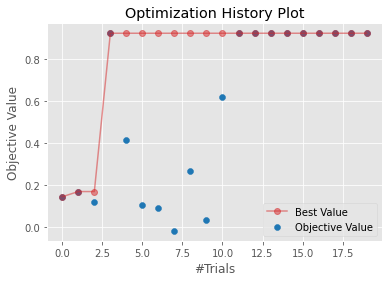

In [ ]:
op.visualization.matplotlib.plot_optimization_history(study)

Plot optimization history of all trials in a study.

The line plot indicates the best accuracy in complete trial run amongst all and  blue indicates individual trial accuracy.

# Linear Regression

In [10]:
def evalmetric(y,ypred):
 import numpy as np
 e = y - ypred 
 mse_f = np.mean(e**2)
 rmse_f = np.sqrt(mse_f)
 mae_f = np.mean(abs(e))
 mape_f = 100*np.mean(abs(e/y))
 r2_f = 1-(sum(e**2)/sum((y-np.mean(y))**2))
 print("MSE:", mse_f)
 print("RMSE:", rmse_f)
 print("MAE:",mae_f)
 print("MAPE:",mape_f)
 print("R-Squared:", r2_f)

In [12]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
LR = LinearRegression()

# fit the model with data
LR.fit(X_train,y_train)

#
y_predLR=LR.predict(X_test)
evalmetric(y_test,y_predLR)

MSE: 22.127759402996112
RMSE: 4.704015242640708
MAE: 3.743797176753162
MAPE: 0.8275276750396894
R-Squared: 0.9235430062617523


In [14]:
#To get the coeffient
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
LRM=sm.OLS(y_train,X2)
result=LRM.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.539e+04
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        07:02:00   Log-Likelihood:                -22407.
No. Observations:                7654   AIC:                         4.482e+04
Df Residuals:                    7649   BIC:                         4.486e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        458.1192     10.737     42.668      0.0

A) Which variables are significantly diffrent than 0 at 5% significant level?

B)Among signicant variables, which one increases dependent variable (Y)?

C)How can we interpret coefficent?

In [15]:
corr = X_train.corr()

corr

,AT,V,AP,RH
AT,1.000000,0.845196,-0.503637,-0.540861
V,0.845196,1.000000,-0.413232,-0.308697
AP,-0.503637,-0.413232,1.000000,0.099628
RH,-0.540861,-0.308697,0.099628,1.000000


## Boosting

In [16]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    x, y = X_train,y_train

    regressor_name = trial.suggest_categorical("regressor", ["GradientBoosting", "XGBoost","LightGBM","RandomForest"])
    if regressor_name == "GradientBoosting":
         max_depth = trial.suggest_int("max_depth", 2,16)
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = sklearn.ensemble.GradientBoostingRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )
    
    elif regressor_name == "XGBoost":
         from xgboost import XGBRegressor
         max_depth = trial.suggest_int("max_depth", 2,X_train.shape[1])
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = XGBRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )
        
         

    elif regressor_name == "LightGBM":
         import lightgbm as lgb
         max_depth = trial.suggest_int("max_depth", 2,X_train.shape[1])
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = lgb.LGBMRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )
        
       
   
    else:
         max_depth = trial.suggest_int("max_depth", 2,16)
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = sklearn.ensemble.RandomForestRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )

     

    r2=sklearn.model_selection.cross_val_score(regressor_obj, x, y, n_jobs=-1, cv=3).mean()
   
    return r2


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)
    print(study.best_trial)

[I 2022-04-01 07:07:18,794] A new study created in memory with name: no-name-f6c41b70-b07d-42dd-9e66-bbb9a4012751
[I 2022-04-01 07:07:21,673] Trial 0 finished with value: 0.9432868995923753 and parameters: {'regressor': 'LightGBM', 'max_depth': 2, 'max_features': 4}. Best is trial 0 with value: 0.9432868995923753.
[I 2022-04-01 07:07:23,943] Trial 1 finished with value: 0.950806764028192 and parameters: {'regressor': 'XGBoost', 'max_depth': 4, 'max_features': 4}. Best is trial 1 with value: 0.950806764028192.
[I 2022-04-01 07:07:26,380] Trial 2 finished with value: 0.9594078049876288 and parameters: {'regressor': 'RandomForest', 'max_depth': 15, 'max_features': 2}. Best is trial 2 with value: 0.9594078049876288.
[I 2022-04-01 07:07:29,685] Trial 3 finished with value: 0.9604578027249041 and parameters: {'regressor': 'GradientBoosting', 'max_depth': 10, 'max_features': 3}. Best is trial 3 with value: 0.9604578027249041.
[I 2022-04-01 07:07:29,814] Trial 4 finished with value: 0.94328689

FrozenTrial(number=17, values=[0.9625906847052871], datetime_start=datetime.datetime(2022, 4, 1, 7, 7, 54, 659152), datetime_complete=datetime.datetime(2022, 4, 1, 7, 7, 56, 925886), params={'regressor': 'GradientBoosting', 'max_depth': 9, 'max_features': 2}, distributions={'regressor': CategoricalDistribution(choices=('GradientBoosting', 'XGBoost', 'LightGBM', 'RandomForest')), 'max_depth': IntUniformDistribution(high=16, low=2, step=1), 'max_features': IntUniformDistribution(high=4, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=17, state=TrialState.COMPLETE, value=None)


In [17]:
params={ 'max_depth': 9, 'max_features': 2}

In [19]:
study.best_params

{'max_depth': 9, 'max_features': 2, 'regressor': 'GradientBoosting'}

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from time import time

gbr = GradientBoostingRegressor(random_state=17,**params)
gbr.fit(X_train, y_train)
print('Train Data')
y_pred = gbr.predict(X_train)
evalmetric(y_train,y_pred)
print('Test Data')
y_pred2 = gbr.predict(X_test)
evalmetric(y_test,y_pred2)

Train Data
MSE: 1.3870578161064235
RMSE: 1.1777341873726956
MAE: 0.9027917177064025
MAPE: 0.19967504532152242
R-Squared: 0.9952446062667375
Test Data
MSE: 9.936407011584965
RMSE: 3.1522066892234344
MAE: 2.1840489729290957
MAPE: 0.482884995857941
R-Squared: 0.9656672058463105


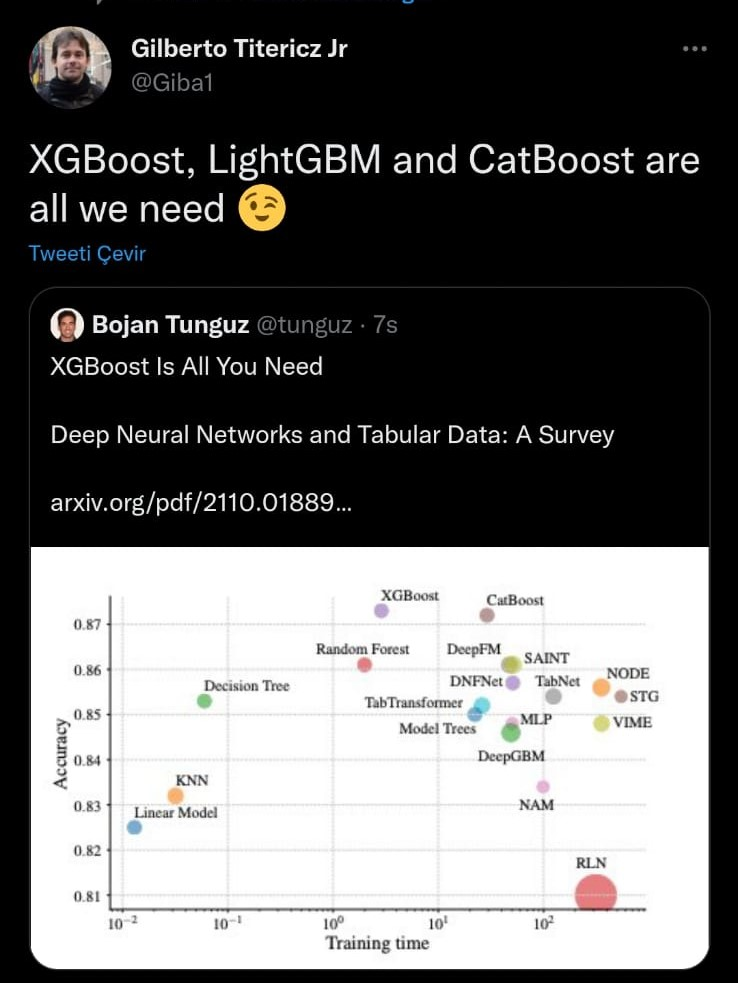